# Detecting the difficulty level of French texts




In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


In [6]:
!python -m spacy download fr_core_news_sm

2023-11-20 08:46:56.591930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 08:46:56.591989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 08:46:56.592019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 08:46:56.597555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 08:46:57.490036: W tensorflow/compiler/

In [7]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 39.6MB/s]


In [8]:
import pandas as pd
import numpy as np

In [9]:
train_data = pd.read_csv('training_data.csv', index_col = 'id')

In [10]:
train_data.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [11]:
train_data.isnull().sum()

sentence      0
difficulty    0
dtype: int64

In [12]:
train_data.duplicated().sum()

0

In [13]:
X_data = train_data['sentence']

In [14]:
y_data = train_data['difficulty']

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [18]:
y_train.shape

(3840,)

In [19]:
X_train.shape

(3840,)

In [20]:
import spacy
from spacy import displacy
import string
from nltk.stem.snowball import SnowballStemmer

In [21]:
#french language
french = spacy.load('fr_core_news_sm')
stemmer = SnowballStemmer(language='french')

In [22]:
test = "Bouygues a eu 1 coupure de réseau à Marseille."
test2 = "Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient "

In [23]:
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = french(sentence)

    # Remove proper nouns (noms propres)
    mytokens = [word for word in mytokens if word.pos_ != "PROPN"]

    # Lemmatize each token and convert each token into lowercase
    mytokens = [stemmer.stem(X.text) for X in mytokens]

    # Remove numbers
    mytokens = [word for word in mytokens if not word.isdigit()]

    # Return preprocessed list of tokens
    return list(mytokens)

In [ ]:
#spacy_tokenizer(test2)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import StandardScaler


pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3)),
])

# Ajustez le modèle sur l'ensemble d'entraînement
pipe.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [26]:
level_pred = pipe.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [28]:
print(f'The accuracy using TF-IDF and Logistic Regression is: {round(accuracy_score(y_test, level_pred), 3)}')
#print(f'Accuracy of the best model: {accuracy_tfidf * 100:.2f}%')
print(f'\nThe precision using TF-IDF and Logistic Regression is: {round(precision_score(y_test, level_pred,average="macro"), 3)}')
print(f'\nThe recall using TF-IDF and Logistic Regression is: {round(recall_score(y_test, level_pred,average="macro"), 3)}')
print(f'\nThe F1-score using TF-IDF and Logistic Regression is: {round(f1_score(y_test, level_pred,average="macro"), 3)}')


The accuracy using TF-IDF and Logistic Regression is: 0.291

The precision using TF-IDF and Logistic Regression is: 0.38

The recall using TF-IDF and Logistic Regression is: 0.286

The F1-score using TF-IDF and Logistic Regression is: 0.261


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

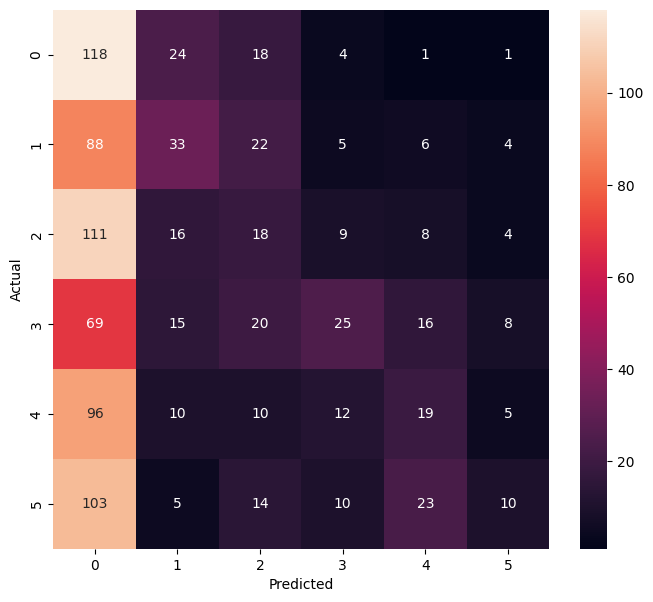

In [ ]:
## Confusion matrix
conf_mat = confusion_matrix(y_test, level_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()